In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install node2vec

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import data
import json
with open('CWE190_Integer_Overflow.json', "r") as file:
    data=json.load(file)

In [4]:
#node_type
# لیستی برای نگهداری خروجی‌ها
node_type = []

# پیمایش و استخراج label مربوط به گره‌ها
for vertex in data['@value']['vertices']:  
    # استخراج شناسه گره
    vertex_id = vertex['id']['@value']  
    id_TYP = vertex_id
    label = vertex['label']
    # اگر label برابر با "BLOCK" نباشد، آن را به لیست اضافه کن
    if label != "BLOCK":
        node_type.append((id_TYP, label))
# چاپ لیست خروجی‌ها
print(node_type)

[(22, 'IDENTIFIER'), (20, 'LOCAL'), (15, 'IDENTIFIER'), (24, 'CALL'), (18, 'CALL'), (23, 'IDENTIFIER'), (26, 'METHOD_RETURN'), (13, 'IDENTIFIER'), (25, 'IDENTIFIER'), (21, 'CALL'), (14, 'CALL'), (9, 'METHOD_PARAMETER_IN'), (12, 'CALL'), (16, 'LITERAL'), (11, 'LOCAL'), (8, 'METHOD'), (19, 'IDENTIFIER')]


In [5]:
#label_encoding
# تبدیل لیست خروجی‌ها به DataFrame
import pandas as pd

# ساخت DataFrame از لیست node_type
df = pd.DataFrame(node_type, columns=['id_TYP' ,'label'] )

# کد دوم: انجام Label Encoding
from sklearn.preprocessing import LabelEncoder

# ایجاد یک شیء از LabelEncoder
label_encoder = LabelEncoder()

# اعمال Label Encoding بر روی ستون 'label'
df['label_encoding'] = label_encoder.fit_transform(df['label'])

# چاپ DataFrame نهایی
#print(df)

# چاپ مقادیر یکتای Label Encoded
#print(df[['label_encoding' , 'id']].unique())

# چاپ مقادیر یکتای Label Encoded
#print(df[['label_encoding', 'id']].drop_duplicates())

# استخراج زوج‌های (label_encoding, id) و تبدیل به لیست
label_encoded_array = list(zip(df['id_TYP'], df['label_encoding']))

print(label_encoded_array)

[(22, 1), (20, 3), (15, 1), (24, 0), (18, 0), (23, 1), (26, 6), (13, 1), (25, 1), (21, 0), (14, 0), (9, 5), (12, 0), (16, 2), (11, 3), (8, 4), (19, 1)]


In [6]:
#node_tokens
node_tokens = []
# پیمایش و جمع آوری مقدار @value مربوط به CONTROL_STRUCTURE_TYPE
for vertex in data['@value']['vertices']:
    # استخراج شناسه گره
    vertex_idt = vertex['id']['@value']  
    id_TKN = vertex_idt
    properties = vertex.get('properties', {})
    control_structure_type = properties.get('CODE', {}).get('@value')
    if control_structure_type is not None:
        node_tokens.append((id_TKN, control_structure_type))
    
# چاپ کردن تمامی control_structure_type ها که داخل آرایه جمع آوری شده اند
print(node_tokens)


[(22, 'VARIABLE_2'), (20, 'unsigned int VARIABLE_2'), (15, 'PARAM_1'), (24, 'printUnsignedLine (VARIABLE_2)'), (18, '++VARIABLE_1'), (23, 'VARIABLE_1'), (26, 'RET'), (13, 'VARIABLE_1'), (25, 'VARIABLE_2'), (21, 'VARIABLE_2 = VARIABLE_1'), (14, 'PARAM_1[2]'), (9, 'unsigned int PARAM_1[]'), (12, 'VARIABLE_1= PARAM_1[2]'), (10, '{\n    unsigned int VARIABLE_1= PARAM_1[2];\n    {\n        ++VARIABLE_1;\n        unsigned int VARIABLE_2 = VARIABLE_1;\n        printUnsignedLine (VARIABLE_2);\n    }\n }'), (17, '{\n        ++VARIABLE_1;\n        unsigned int VARIABLE_2 = VARIABLE_1;\n        printUnsignedLine (VARIABLE_2);\n    }'), (16, '2'), (11, 'unsigned int VARIABLE_1'), (8, 'void CWE190_Integer_Overflow(unsigned int PARAM_1[])\n{\n    unsigned int VARIABLE_1= PARAM_1[2];\n    {\n        ++VARIABLE_1;\n        unsigned int VARIABLE_2 = VARIABLE_1;\n        printUnsignedLine (VARIABLE_2);\n    }\n }'), (19, 'VARIABLE_1')]


In [7]:
#word2vec
from gensim.models import Word2Vec
import re

# پیش پردازش داده‌ها: تبدیل هر رشته به لیست کلمات
def preprocess_text(text):
    # حذف کاراکترهای خاص و تقسیم به کلمات
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    return tokens

# تبدیل تمامی رشته‌ها به لیست کلمات
tokenized_sentences = [preprocess_text(token[1]) for token in node_tokens]

# آموزش مدل Word2Vec
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# آماده‌سازی آرایه نهایی شامل id_TKN و بردار متناظر با control_structure_type
final_array = []
for id_TKN, control_structure_type in node_tokens:
    tokenized_control_structure = preprocess_text(control_structure_type)
    vector_representation = [model.wv[token].tolist() for token in tokenized_control_structure]
    # مسطح کردن بردارها و اضافه کردن به final_array
    for vector in vector_representation:
        final_array.append((id_TKN, vector))
# چاپ آرایه نهایی
print(final_array)


# ذخیره مدل برای استفاده‌های بعدی
model.save("word2vec_model.model")

[(22, [-0.008641772903501987, 0.0036868855822831392, 0.005200562998652458, 0.005770540796220303, 0.007459149230271578, -0.006183544639497995, 0.0011323046637699008, 0.006079539656639099, -0.0028592434246093035, -0.006183328106999397, -0.00038172409404069185, -0.008373575285077095, -0.005598209798336029, 0.007114761509001255, 0.0033597133588045835, 0.0072144377045333385, 0.006816269364207983, 0.007535113487392664, -0.0038305288180708885, -0.0005872733891010284, 0.0023672133684158325, -0.004507122561335564, 0.00842698197811842, -0.009853591211140156, 0.00677840318530798, 0.0029073720797896385, -0.0049253590404987335, 0.004417113959789276, -0.0017645483603700995, 0.0066983518190681934, 0.009957329370081425, -0.004378313198685646, -0.0005814802716486156, -0.005716119892895222, 0.003847020212560892, 0.00279200985096395, 0.0069218846037983894, 0.006087958812713623, 0.009532801806926727, 0.009265774860978127, 0.007872049696743488, -0.006969432346522808, -0.009178044274449348, -0.0003643146483

In [8]:
# فرض می‌کنیم که final_array و label_encoded_array موجود و تعریف شده هستند.

# آرایه نهایی که می‌خواهیم تشکیل دهیم
label_word_array = []

# پیمایش در final_array و label_encoded_array برای پیدا کردن تطابق id_TKN و id_TYP
for id_TKN, vector in final_array:
    for id_TYP, label_encoding in label_encoded_array:
        if id_TKN == id_TYP:
            label_word_array.append((label_encoding, vector))

# چاپ آرایه نهایی
print(label_word_array)


[(1, [-0.008641772903501987, 0.0036868855822831392, 0.005200562998652458, 0.005770540796220303, 0.007459149230271578, -0.006183544639497995, 0.0011323046637699008, 0.006079539656639099, -0.0028592434246093035, -0.006183328106999397, -0.00038172409404069185, -0.008373575285077095, -0.005598209798336029, 0.007114761509001255, 0.0033597133588045835, 0.0072144377045333385, 0.006816269364207983, 0.007535113487392664, -0.0038305288180708885, -0.0005872733891010284, 0.0023672133684158325, -0.004507122561335564, 0.00842698197811842, -0.009853591211140156, 0.00677840318530798, 0.0029073720797896385, -0.0049253590404987335, 0.004417113959789276, -0.0017645483603700995, 0.0066983518190681934, 0.009957329370081425, -0.004378313198685646, -0.0005814802716486156, -0.005716119892895222, 0.003847020212560892, 0.00279200985096395, 0.0069218846037983894, 0.006087958812713623, 0.009532801806926727, 0.009265774860978127, 0.007872049696743488, -0.006969432346522808, -0.009178044274449348, -0.00036431464832

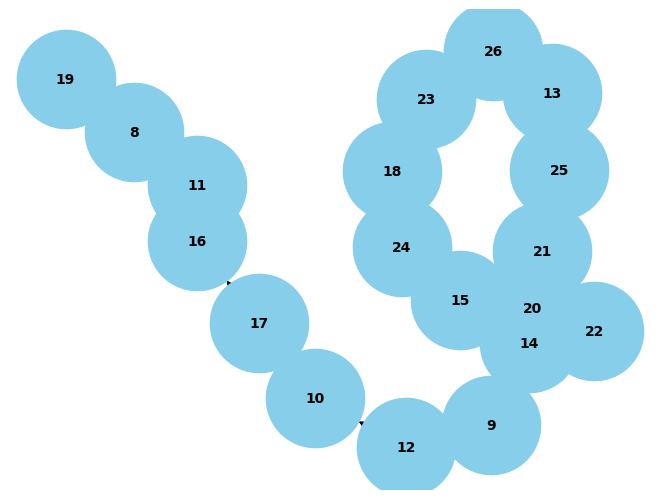

Computing transition probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

[(22, [0.06113129, 0.062347215, 0.4812033, 0.037063044, -0.069981344, -0.09672034, -0.21906875, -0.14710814, 0.05426173, -0.20980744, 0.32445267, -0.062691435, -0.07301171, 0.013297754, -0.25192258, -0.14202443, -0.19577071, -0.048284426, -0.14179865, 0.23134199, 0.11409857, -0.038100865, 0.37791008, 0.05851934, -0.14397636, 0.4488657, -0.37014672, -0.117882684, -0.31742427, -0.2310487, -0.13615936, -0.10251103, -0.37286925, -0.18955305, 0.20900741, 0.05114093, -0.05065946, 0.17938688, 0.29844537, 0.17575018, 0.11914893, 0.13564144, -0.26201868, -0.5005499, 0.03638373, -0.31801623, -0.083560236, -0.045243368, -0.08225698, -0.20787434, 0.13424501, 0.18596575, 0.03914681, 0.27829444, 0.25976473, 0.152284, 0.27328235, -0.17432925, 0.011531706, 0.08330392, -0.057557017, -0.17714883, -0.027421305, 0.13450722]), (20, [0.065569535, 0.06236313, 0.52611613, 0.04043769, -0.074986316, -0.08956207, -0.23847735, -0.14655282, 0.07824168, -0.2268052, 0.335974, -0.08308666, -0.047325145, 0.019401133, 

In [9]:
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

# بخش دوم: ایجاد گراف و اجرای node2vec بر روی آن
# ایجاد گراف
G = nx.DiGraph()

# اضافه کردن گره‌ها
for token in node_tokens:
    G.add_node(token[0])  # اضافه کردن شناسه گره به گراف

# اضافه کردن یال‌ها
for i in range(len(node_tokens) - 1):
    G.add_edge(node_tokens[i][0], node_tokens[i + 1][0])  # اضافه کردن یال بین گره‌ها

# نمایش گراف
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.show()

# ایجاد node2vec
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=100, workers=4)

# یادگیری مدل
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# نمایش بردارها به همراه شناسه گره
node2vec = [(node, list(model.wv[str(node)])) for node in G.nodes]
print(node2vec)

# بردار یک گره خاص را به دست آورید
# vector = model.wv['VARIABLE_2']
# print(f"Vector for 'VARIABLE_2': {vector}")


In [10]:
#label_encoded_array +node2vec_array
# استخراج بردارها به همراه شناسه گره
node2vec_array = [(node, list(model.wv[str(node)])) for node in G.nodes]
print("Node2Vec Array:")
print(node2vec_array)

combined_array = [(label_encoding, node_vec) for id_TYP, label_encoding in label_encoded_array for node, node_vec in node2vec_array if id_TYP == node]
print("Combined Array:")
print(combined_array)

Node2Vec Array:
[(22, [0.06113129, 0.062347215, 0.4812033, 0.037063044, -0.069981344, -0.09672034, -0.21906875, -0.14710814, 0.05426173, -0.20980744, 0.32445267, -0.062691435, -0.07301171, 0.013297754, -0.25192258, -0.14202443, -0.19577071, -0.048284426, -0.14179865, 0.23134199, 0.11409857, -0.038100865, 0.37791008, 0.05851934, -0.14397636, 0.4488657, -0.37014672, -0.117882684, -0.31742427, -0.2310487, -0.13615936, -0.10251103, -0.37286925, -0.18955305, 0.20900741, 0.05114093, -0.05065946, 0.17938688, 0.29844537, 0.17575018, 0.11914893, 0.13564144, -0.26201868, -0.5005499, 0.03638373, -0.31801623, -0.083560236, -0.045243368, -0.08225698, -0.20787434, 0.13424501, 0.18596575, 0.03914681, 0.27829444, 0.25976473, 0.152284, 0.27328235, -0.17432925, 0.011531706, 0.08330392, -0.057557017, -0.17714883, -0.027421305, 0.13450722]), (20, [0.065569535, 0.06236313, 0.52611613, 0.04043769, -0.074986316, -0.08956207, -0.23847735, -0.14655282, 0.07824168, -0.2268052, 0.335974, -0.08308666, -0.04732514

In [7]:
#word2vec
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")   

# بارگذاری مدل Word2Vec
model = Word2Vec.load("word2vec.model")

# تبدیل node_tokens به فرمت ورودی مورد نیاز برای model.train
# در اینجا فرض می‌کنیم هر token یک جمله مجزا است
sentences = [token.split() for token in node_tokens]

# آموزش مجدد مدل با استفاده از داده‌های جدید
model.train(sentences, total_examples=len(sentences), epochs=1)

# ذخیره مدل به روز شده (اختیاری)
model.save("word2vec_updated.model")

In [8]:
from gensim.models import KeyedVectors
# Store just the words + their trained embeddings.
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['computer']  # Get numpy vector of a word

In [9]:

from gensim.test.utils import datapath
# Load a word2vec model stored in the C *text* format.
wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)
# Load a word2vec model stored in the C *binary* format.
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)

In [10]:
word_vectors = model.wv
del model